# Testing isostatic boundary conditions in UW2

This is a check to make sure UW2's pressure boundary condition properly works.

The setup is:

     <--------- 100 km ------------>
    _________________________________
    |                               |  ^
    |                               |  |
    |     incompressible air        |  50 km 
    |        1 kg.m^-3              |  |
    |                               |  | 
    |_______________________________|  v 
    |        crust                  |  ^ 
    |        500 kg.m^-3            |  25 km 
    |_______________________________|  v 
    |        mantle                 |  ^ 
    |        1000 kg.m^-3           |  25 km 
    |_______________________________|  v 

We pull each vertical wall at 1 cm/yr (total extension is 2 cm/yr)
The bottom wall as a pressure boundary condition

In this experiment, we will try changing the boundary conditions to evaluate the impact.

In this case, the top boundary condition is opened, allowing air to flow in. This means we can make the air incompressible, allowing us to the use the penalty method.

In [1]:
import underworld as uw
import UWGeodynamics as GEO
import numpy as np
import matplotlib.pyplot as plt

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry
GEO.rcParams['solver'] = "mumps"
GEO.rcParams["surface.pressure.normalization"] = True

GEO.rcParams["penalty"] = 1e6

# Use some higher order elements to get a nicer solution
GEO.rcParams["element.type"] = "Q2/dQ1"

# Use the fancier advection diffusion method
GEO.rcParams["advection.diffusion.method"] = "SLCN"

# Normally this is 0.5, but it can make it easier for the solver if you reduce this number.
GEO.rcParams["CFL"] = 0.25

# Adjust how particles populate the model. Because this model has a big load of inflowing material,
# I like to have these very aggressive
GEO.rcParams["popcontrol.split.threshold"] = 0.95
GEO.rcParams["popcontrol.max.splits"] = 100
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 60
GEO.rcParams["swarm.particles.per.cell.2D"] = 60

In [3]:
# This is all for scaling the model
# most of it is pretty self explanitory, try to make them match your setup as best as possible
half_rate = 1.0 * u.centimeter / u.year
model_length = 100e3 * u.meter
model_height = 100e3 * u.meter
refViscosity = 1e22 * u.pascal * u.second
bodyforce = 500 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [4]:
# Setup the model domain and resolution. The 'divisor' is just an easy way to adjust the resolution
divisor = 4
Model = GEO.Model(elementRes=(int(100/divisor),int(100/divisor)), 
                  minCoord=(-50 * u.kilometer, -50 * u.kilometer),
                  maxCoord=( 50 * u.kilometer,  50 * u.kilometer))

In [5]:
air = Model.add_material(name="air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0))
uc =  Model.add_material(name="crust",  shape=GEO.shapes.Layer2D(top=air.bottom, bottom=-25*u.kilometer))
mantle = Model.add_material(name="mantle",  shape=GEO.shapes.Layer2D(top=uc.bottom, bottom=Model.bottom))

# We use 'easy' numbers here, so the analytical calculation is easier.
air.density    =    1. * u.kilogram / u.metre**3
uc.density     =  500. * u.kilogram / u.metre**3
mantle.density = 1000. * u.kilogram / u.metre**3


air.viscosity    = 1e19 * u.pascal * u.second
uc.viscosity     = 1e21 * u.pascal * u.second  # If you make everything the same viscosity, UW goes a bit wild, so 
mantle.viscosity = 1e20 * u.pascal * u.second  # by making these different, it gives the solver something to 'do'.


# we need to make the air compressible, so we can put a no infow boundary condition on the top of the model
#air.compressibility = 1e3  # Not sure what's a good value

In [6]:
# We need to initialise the model before calculating anything to serious (like the lithostatic pressure)
Model.init_model()

# This is where isostasy is imposed. We first calculate the lithostatic pressure along the entire bottom of the model. 
P, bottomPress = Model.get_lithostatic_pressureField()

# Then, since the model is laterally homogenous, we average it, and put it into megapascals
bottomPress = GEO.Dimensionalize(np.average(bottomPress), u.megapascal)


# This is where we apply the boundary conditions. As a rule of thumb, the more information we can give to UW, the happier
# it will be. For example, we could make the top a free slip condition:
#     top=[None , 0. * u.centimetre / u.year]
# but really, we don't care much about the top of the air, so giving 'extra info' in the form of a no-slip condition
# helps UW figure out what's going on.
# Try removing various bits of information to compare how the model performs.
Model.set_velocityBCs(left   = [-1.0 * u.centimetre / u.year, 0 * u.centimetre / u.year], 
                      right  = [1.0 * u.centimetre / u.year,  0 * u.centimetre / u.year], 
                      #top    = [0 * u.centimetre / u.year,    0. * u.centimetre / u.year], 
                      bottom = [None,                         bottomPress]) # This is where the pressure boundary is applied.

In [7]:
# Here we setup a passive tracer - just one particle, right at the top of the crust, right in the middle of the
# model. Hopefully it won't advect too much in either direction, but really we only care about its height.
mswarm = uw.swarm.Swarm( mesh=Model.mesh, particleEscape=True )
msAdvector= uw.systems.SwarmAdvector(Model.velocityField, mswarm, order=4)

height_through_time = []

particleCoordinates = np.zeros((1,2))
particleCoordinates[:,0] = 0
particleCoordinates[:,1] = 0
_ = mswarm.add_particles_with_coordinates(particleCoordinates)

# Here we have to tell UWGeodynamics that we have some extra work to do at the end of each solve
def advect_passive():
    msAdvector.integrate(Model._dt)
    height_through_time.append((Model.time.magnitude, GEO.Dimensionalize(mswarm.particleCoordinates.data[:,1].copy()[0], u.kilometer).magnitude))
    #mswarm.[:,0] = 0  # reset back to centre - not sure how to do this.
Model.postSolveHook = advect_passive

In [8]:
# This is a bunch of solver options. You can try playing with them, but these should be good enough.
Model.solver = Model.stokes_solver()
Model.solver.options.A11.ksp_rtol=1e-8
Model.solver.options.scr.ksp_rtol=1e-8
Model.solver.options.scr.use_previous_guess = True
Model.solver.options.scr.ksp_set_min_it_converge = 10
Model.solver.options.scr.ksp_type = "cg"
Model.solver.options.main.remove_constant_pressure_null_space=True


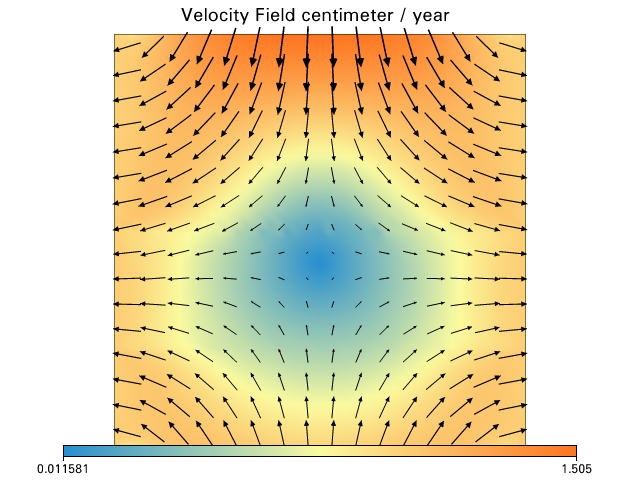


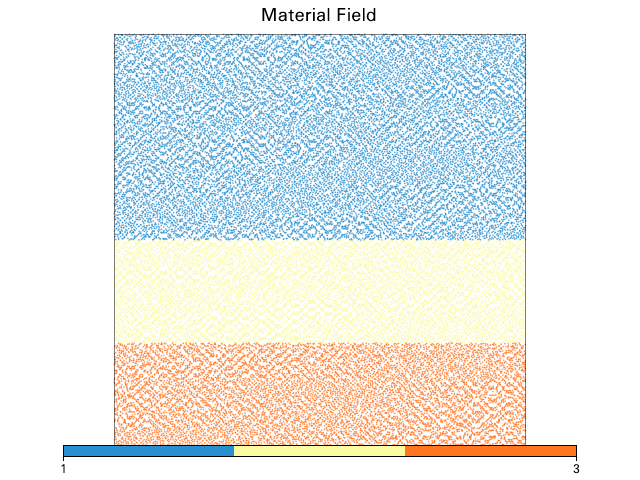

In [9]:
# Do an initial solve to give us a look at what's happening.
Model.solve()
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

## Run model for 5 Myr increments, and show the results

In [10]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  16611.489394859906 year dt: 16611.489394859906 year (2018-10-25 05:15:35)
Step:2 Model Time:  32200.551044211614 year dt: 15589.06164935171 year (2018-10-25 05:15:35)
Step:3 Model Time:  47792.141033888576 year dt: 15591.58998967696 year (2018-10-25 05:15:36)
Step:4 Model Time:  63731.76557561749 year dt: 15939.624541728921 year (2018-10-25 05:15:36)
Step:5 Model Time:  79770.42884483786 year dt: 16038.663269220375 year (2018-10-25 05:15:37)
Step:6 Model Time:  96138.22001100074 year dt: 16367.791166162868 year (2018-10-25 05:15:37)
Step:7 Model Time:  113288.04181000146 year dt: 17149.821799000718 year (2018-10-25 05:15:37)
Step:8 Model Time:  130623.85620302027 year dt: 17335.814393018827 year (2018-10-25 05:15:38)
Step:9 Model Time:  148123.831167618 year dt: 17499.974964597703 year (2018-10-25 05:15:38)
Step:10 Model Time:  165647.9068045553 year dt: 17524.0756369373 year (2018-10-25 05:15:39)
Ste

Step:88 Model Time:  1360480.2234593928 year dt: 16506.782542375313 year (2018-10-25 05:16:11)
Step:89 Model Time:  1376714.1172277946 year dt: 16233.893768401955 year (2018-10-25 05:16:11)
Step:90 Model Time:  1393258.9578327332 year dt: 16544.84060493876 year (2018-10-25 05:16:12)
Step:91 Model Time:  1409239.5180747898 year dt: 15980.560242056737 year (2018-10-25 05:16:12)
Step:92 Model Time:  1424464.1007943167 year dt: 15224.582719526898 year (2018-10-25 05:16:12)
Step:93 Model Time:  1440097.5955103613 year dt: 15633.494716044423 year (2018-10-25 05:16:13)
Step:94 Model Time:  1455992.1698646832 year dt: 15894.574354322065 year (2018-10-25 05:16:13)
Step:95 Model Time:  1471820.2175691838 year dt: 15828.047704500552 year (2018-10-25 05:16:14)
Step:96 Model Time:  1486837.216455511 year dt: 15016.998886327368 year (2018-10-25 05:16:14)
Step:97 Model Time:  1501702.3669038594 year dt: 14865.150448348353 year (2018-10-25 05:16:14)
Step:98 Model Time:  1516745.061525033 year dt: 1504

Step:175 Model Time:  2688163.7193961632 year dt: 16343.832904641995 year (2018-10-25 05:16:47)
Step:176 Model Time:  2704176.0439145197 year dt: 16012.324518356714 year (2018-10-25 05:16:48)
Step:177 Model Time:  2719685.1391433035 year dt: 15509.095228783937 year (2018-10-25 05:16:48)
Step:178 Model Time:  2735414.042273567 year dt: 15728.90313026327 year (2018-10-25 05:16:48)
Step:179 Model Time:  2751104.865067837 year dt: 15690.822794269958 year (2018-10-25 05:16:49)
Step:180 Model Time:  2766049.533190759 year dt: 14944.668122922103 year (2018-10-25 05:16:49)
Step:181 Model Time:  2781138.9441429633 year dt: 15089.410952204467 year (2018-10-25 05:16:50)
Step:182 Model Time:  2795960.127863628 year dt: 14821.183720664632 year (2018-10-25 05:16:50)
Step:183 Model Time:  2811285.032329358 year dt: 15324.90446573054 year (2018-10-25 05:16:51)
Step:184 Model Time:  2826234.59658954 year dt: 14949.564260182431 year (2018-10-25 05:16:51)
Step:185 Model Time:  2841520.526103101 year dt: 

Step:262 Model Time:  4016174.091808485 year dt: 15769.185077896853 year (2018-10-25 05:17:24)
Step:263 Model Time:  4032346.028945662 year dt: 16171.937137177623 year (2018-10-25 05:17:24)
Step:264 Model Time:  4047576.5145439766 year dt: 15230.485598314386 year (2018-10-25 05:17:24)
Step:265 Model Time:  4062596.162115909 year dt: 15019.647571932746 year (2018-10-25 05:17:25)
Step:266 Model Time:  4079282.7718075807 year dt: 16686.609691671383 year (2018-10-25 05:17:25)
Step:267 Model Time:  4093179.681923145 year dt: 13896.910115564433 year (2018-10-25 05:17:26)
Step:268 Model Time:  4107674.4244532348 year dt: 14494.742530089583 year (2018-10-25 05:17:26)
Step:269 Model Time:  4122449.80652562 year dt: 14775.382072385617 year (2018-10-25 05:17:27)
Step:270 Model Time:  4137789.2167408695 year dt: 15339.41021524891 year (2018-10-25 05:17:27)
Step:271 Model Time:  4153004.2312695617 year dt: 15215.014528692307 year (2018-10-25 05:17:27)
Step:272 Model Time:  4168624.519187138 year dt

1


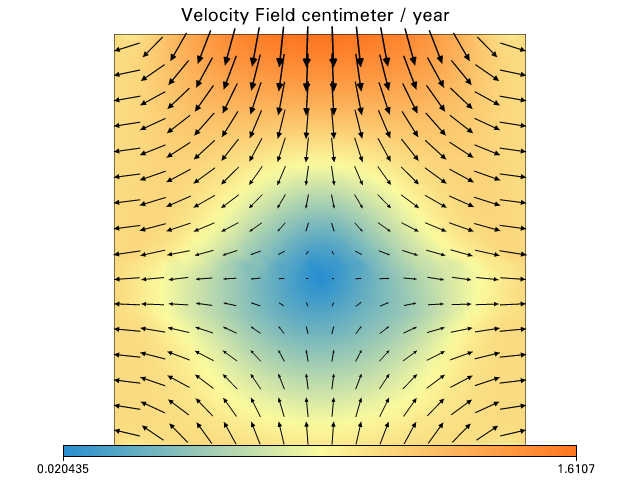


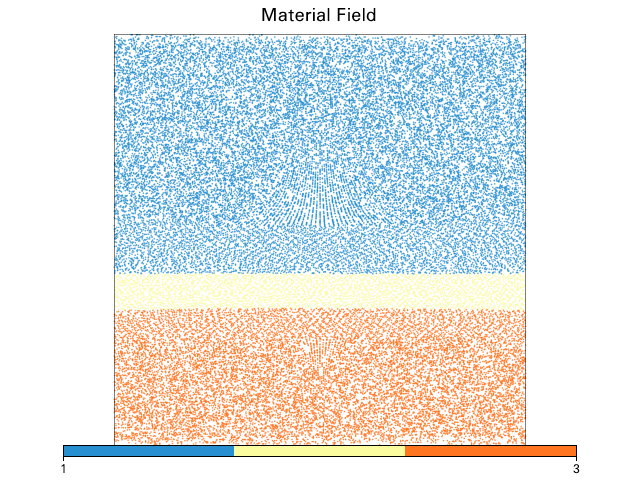

Text(0.5,1,'Subsidence of surface during thinning')

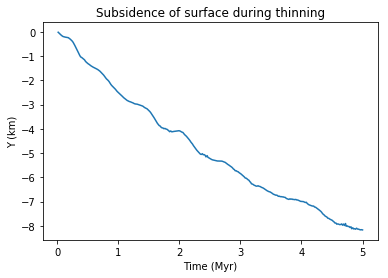

In [11]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [12]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  5014729.549367341 year dt: 14729.549367343869 year (2018-10-25 05:17:55)
Step:2 Model Time:  5030740.453879289 year dt: 16010.904511948416 year (2018-10-25 05:17:55)
Step:3 Model Time:  5048068.496689656 year dt: 17328.042810365892 year (2018-10-25 05:17:55)
Step:4 Model Time:  5065096.199746982 year dt: 17027.70305732711 year (2018-10-25 05:17:56)
Step:5 Model Time:  5082503.444318284 year dt: 17407.244571302483 year (2018-10-25 05:17:56)
Step:6 Model Time:  5098940.096547847 year dt: 16436.652229562427 year (2018-10-25 05:17:57)
Step:7 Model Time:  5113296.475776298 year dt: 14356.3792284513 year (2018-10-25 05:17:57)
Step:8 Model Time:  5130435.234837401 year dt: 17138.759061102155 year (2018-10-25 05:17:57)
Step:9 Model Time:  5144850.207535793 year dt: 14414.97269839265 year (2018-10-25 05:17:58)
Step:10 Model Time:  5161062.671659875 year dt: 16212.464124081358 year (2018-10-25 05:17:58)
Step:11

Step:88 Model Time:  6324241.798046183 year dt: 14889.4673314919 year (2018-10-25 05:18:32)
Step:89 Model Time:  6339073.824003075 year dt: 14832.025956892681 year (2018-10-25 05:18:32)
Step:90 Model Time:  6354231.422647821 year dt: 15157.59864474525 year (2018-10-25 05:18:33)
Step:91 Model Time:  6371901.7992851855 year dt: 17670.37663736493 year (2018-10-25 05:18:33)
Step:92 Model Time:  6387497.050054337 year dt: 15595.250769150252 year (2018-10-25 05:18:33)
Step:93 Model Time:  6403770.596513235 year dt: 16273.54645889813 year (2018-10-25 05:18:34)
Step:94 Model Time:  6418516.10887471 year dt: 14745.512361475481 year (2018-10-25 05:18:34)
Step:95 Model Time:  6434269.513320364 year dt: 15753.404445653821 year (2018-10-25 05:18:35)
Step:96 Model Time:  6449301.274410034 year dt: 15031.761089669337 year (2018-10-25 05:18:35)
Step:97 Model Time:  6464539.605001455 year dt: 15238.33059142164 year (2018-10-25 05:18:36)
Step:98 Model Time:  6481620.3336408315 year dt: 17080.72863937667

Step:175 Model Time:  7647423.713066186 year dt: 17549.169259161565 year (2018-10-25 05:19:09)
Step:176 Model Time:  7660997.066494712 year dt: 13573.353428526476 year (2018-10-25 05:19:10)
Step:177 Model Time:  7674838.7081552 year dt: 13841.641660487301 year (2018-10-25 05:19:10)
Step:178 Model Time:  7691769.53756078 year dt: 16930.82940558028 year (2018-10-25 05:19:10)
Step:179 Model Time:  7705119.292162183 year dt: 13349.754601403361 year (2018-10-25 05:19:11)
Step:180 Model Time:  7718710.464392054 year dt: 13591.172229871383 year (2018-10-25 05:19:11)
Step:181 Model Time:  7735252.985803305 year dt: 16542.521411250156 year (2018-10-25 05:19:12)
Step:182 Model Time:  7747700.64446654 year dt: 12447.658663234564 year (2018-10-25 05:19:12)
Step:183 Model Time:  7765844.1187864235 year dt: 18143.47431988432 year (2018-10-25 05:19:12)
Step:184 Model Time:  7778392.249855658 year dt: 12548.131069234252 year (2018-10-25 05:19:13)
Step:185 Model Time:  7797267.830012933 year dt: 18875.

Step:262 Model Time:  8952397.841791937 year dt: 15006.509128461856 year (2018-10-25 05:19:47)
Step:263 Model Time:  8967478.618310371 year dt: 15080.776518435277 year (2018-10-25 05:19:47)
Step:264 Model Time:  8983392.942776138 year dt: 15914.32446576635 year (2018-10-25 05:19:48)
Step:265 Model Time:  9000015.347938184 year dt: 16622.405162046252 year (2018-10-25 05:19:48)
Step:266 Model Time:  9014464.218934324 year dt: 14448.870996138183 year (2018-10-25 05:19:49)
Step:267 Model Time:  9029221.391549667 year dt: 14757.17261534323 year (2018-10-25 05:19:49)
Step:268 Model Time:  9042990.246052768 year dt: 13768.854503102553 year (2018-10-25 05:19:50)
Step:269 Model Time:  9059317.0858883 year dt: 16326.839835532806 year (2018-10-25 05:19:50)
Step:270 Model Time:  9072887.165370615 year dt: 13570.079482313953 year (2018-10-25 05:19:51)
Step:271 Model Time:  9091229.836779246 year dt: 18342.67140863217 year (2018-10-25 05:19:51)
Step:272 Model Time:  9103872.004634721 year dt: 12642.

1


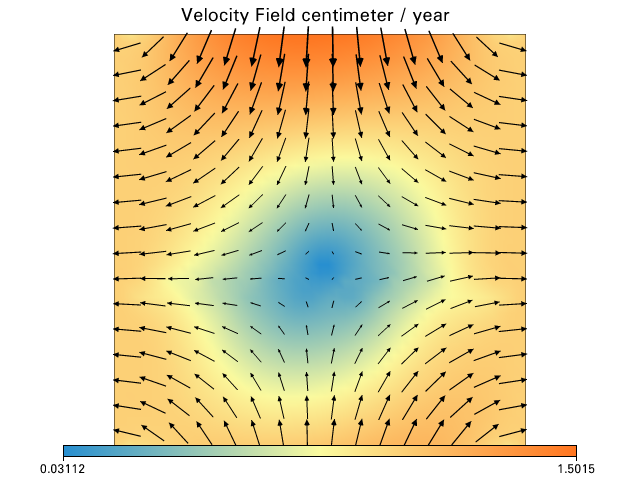


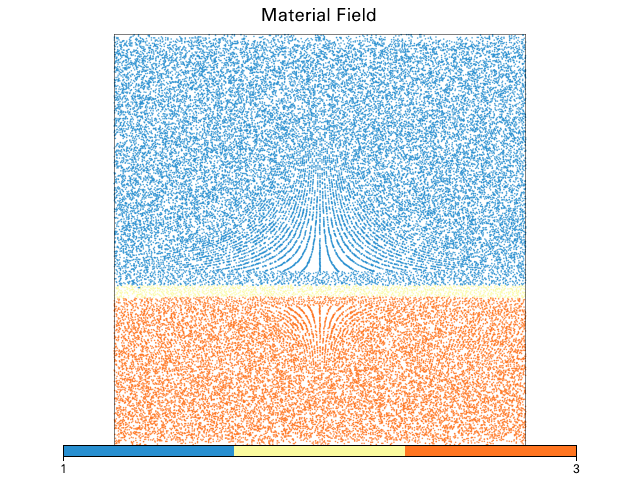

Text(0.5,1,'Subsidence of surface during thinning')

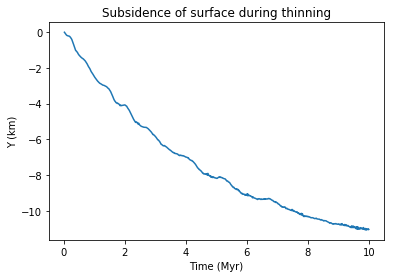

In [13]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [14]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  10012487.663137048 year dt: 12487.66313703977 year (2018-10-25 05:20:21)
Step:2 Model Time:  10030348.457040077 year dt: 17860.793903027876 year (2018-10-25 05:20:21)
Step:3 Model Time:  10043155.404389778 year dt: 12806.947349701783 year (2018-10-25 05:20:22)
Step:4 Model Time:  10058802.166198583 year dt: 15646.761808804833 year (2018-10-25 05:20:22)
Step:5 Model Time:  10075693.403307745 year dt: 16891.2371091611 year (2018-10-25 05:20:23)
Step:6 Model Time:  10089420.907634987 year dt: 13727.50432724068 year (2018-10-25 05:20:23)
Step:7 Model Time:  10107038.14896977 year dt: 17617.24133478199 year (2018-10-25 05:20:24)
Step:8 Model Time:  10119232.447283942 year dt: 12194.298314171909 year (2018-10-25 05:20:24)
Step:9 Model Time:  10137148.260127503 year dt: 17915.81284356082 year (2018-10-25 05:20:24)
Step:10 Model Time:  10148176.294881515 year dt: 11028.034754012735 year (2018-10-25 05:20:25)


Step:88 Model Time:  11326767.251323733 year dt: 14631.406032132609 year (2018-10-25 05:21:00)
Step:89 Model Time:  11341915.848119173 year dt: 15148.596795439793 year (2018-10-25 05:21:00)
Step:90 Model Time:  11357164.78034898 year dt: 15248.93222980772 year (2018-10-25 05:21:01)
Step:91 Model Time:  11372003.647477752 year dt: 14838.86712876942 year (2018-10-25 05:21:01)
Step:92 Model Time:  11387277.761658551 year dt: 15274.114180799217 year (2018-10-25 05:21:02)
Step:93 Model Time:  11403317.699214138 year dt: 16039.937555587667 year (2018-10-25 05:21:02)
Step:94 Model Time:  11417969.160810115 year dt: 14651.461595976323 year (2018-10-25 05:21:03)
Step:95 Model Time:  11434188.088423356 year dt: 16218.927613240743 year (2018-10-25 05:21:03)
Step:96 Model Time:  11447290.318497675 year dt: 13102.230074319454 year (2018-10-25 05:21:03)
Step:97 Model Time:  11463056.553763902 year dt: 15766.235266226893 year (2018-10-25 05:21:04)
Step:98 Model Time:  11477759.558170717 year dt: 1470

Step:174 Model Time:  12603323.345883142 year dt: 12505.139296304867 year (2018-10-25 05:21:39)
Step:175 Model Time:  12618661.591409322 year dt: 15338.24552618071 year (2018-10-25 05:21:39)
Step:176 Model Time:  12633764.506745355 year dt: 15102.915336031157 year (2018-10-25 05:21:40)
Step:177 Model Time:  12649164.876698319 year dt: 15400.369952963352 year (2018-10-25 05:21:40)
Step:178 Model Time:  12664265.791458998 year dt: 15100.914760679161 year (2018-10-25 05:21:41)
Step:179 Model Time:  12680634.965938702 year dt: 16369.174479704312 year (2018-10-25 05:21:41)
Step:180 Model Time:  12692622.363471149 year dt: 11987.39753244569 year (2018-10-25 05:21:41)
Step:181 Model Time:  12711511.942489807 year dt: 18889.579018659086 year (2018-10-25 05:21:42)
Step:182 Model Time:  12721856.714166453 year dt: 10344.771676645594 year (2018-10-25 05:21:42)
Step:183 Model Time:  12739163.733626246 year dt: 17307.019459792056 year (2018-10-25 05:21:43)
Step:184 Model Time:  12749755.984683953 y

Step:260 Model Time:  13791159.783601908 year dt: 9789.340936874576 year (2018-10-25 05:22:18)
Step:261 Model Time:  13804327.269642916 year dt: 13167.486041007916 year (2018-10-25 05:22:18)
Step:262 Model Time:  13812346.231452188 year dt: 8018.961809272169 year (2018-10-25 05:22:19)
Step:263 Model Time:  13825299.96898381 year dt: 12953.737531623492 year (2018-10-25 05:22:19)
Step:264 Model Time:  13833648.361350302 year dt: 8348.392366490778 year (2018-10-25 05:22:20)
Step:265 Model Time:  13847587.48154381 year dt: 13939.12019350948 year (2018-10-25 05:22:20)
Step:266 Model Time:  13855795.792556597 year dt: 8208.311012786527 year (2018-10-25 05:22:20)
Step:267 Model Time:  13869323.644982114 year dt: 13527.852425517907 year (2018-10-25 05:22:21)
Step:268 Model Time:  13877495.939160833 year dt: 8172.294178717599 year (2018-10-25 05:22:21)
Step:269 Model Time:  13890112.253025994 year dt: 12616.313865161801 year (2018-10-25 05:22:22)
Step:270 Model Time:  13898448.056288574 year dt

Step:346 Model Time:  14893698.886369903 year dt: 11489.506640382233 year (2018-10-25 05:22:57)
Step:347 Model Time:  14908804.290876042 year dt: 15105.404506138688 year (2018-10-25 05:22:57)
Step:348 Model Time:  14918443.24399683 year dt: 9638.953120788705 year (2018-10-25 05:22:58)
Step:349 Model Time:  14933463.1661556 year dt: 15019.922158770458 year (2018-10-25 05:22:58)
Step:350 Model Time:  14942780.75443016 year dt: 9317.58827455901 year (2018-10-25 05:22:59)
Step:351 Model Time:  14958755.921589116 year dt: 15975.167158956914 year (2018-10-25 05:22:59)
Step:352 Model Time:  14969052.180497903 year dt: 10296.258908788619 year (2018-10-25 05:23:00)
Step:353 Model Time:  14985886.202749208 year dt: 16834.022251303762 year (2018-10-25 05:23:00)
Step:354 Model Time:  14996788.568625879 year dt: 10902.365876671201 year (2018-10-25 05:23:01)
Step:355 Model Time:  15000000.000000017 year dt: 3211.4313741371525 year (2018-10-25 05:23:01)


1


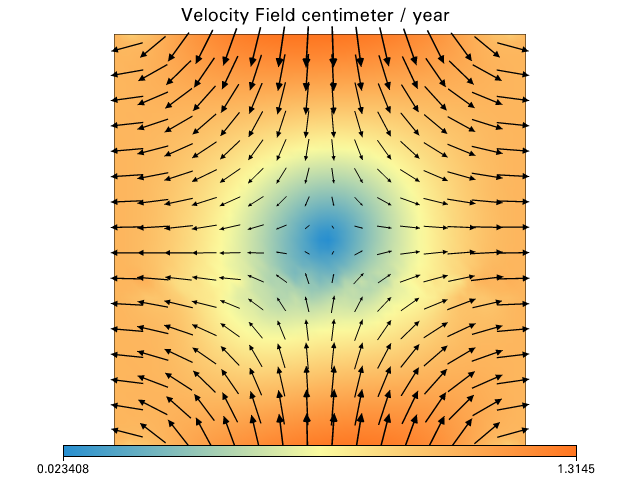


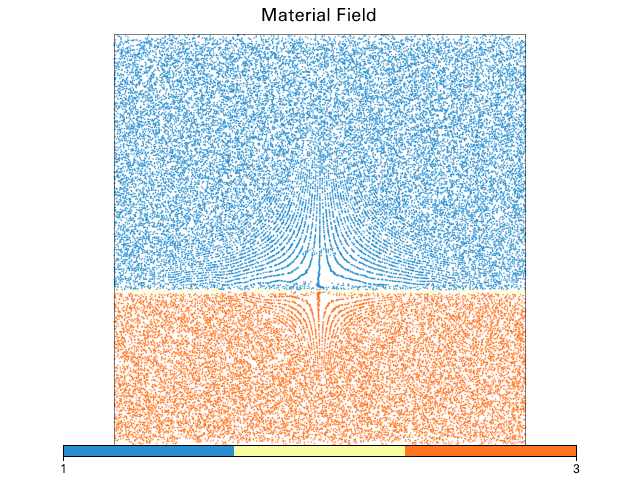

Text(0.5,1,'Subsidence of surface during thinning')

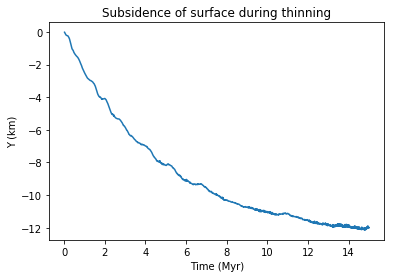

In [15]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [16]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  15017822.305757316 year dt: 17822.305757299888 year (2018-10-25 05:23:04)
Step:2 Model Time:  15029612.825351216 year dt: 11790.5195938994 year (2018-10-25 05:23:04)
Step:3 Model Time:  15046770.048372393 year dt: 17157.2230211781 year (2018-10-25 05:23:05)
Step:4 Model Time:  15058054.830049206 year dt: 11284.781676811697 year (2018-10-25 05:23:05)
Step:5 Model Time:  15074348.554928323 year dt: 16293.724879118332 year (2018-10-25 05:23:06)
Step:6 Model Time:  15084385.986898039 year dt: 10037.431969716084 year (2018-10-25 05:23:06)
Step:7 Model Time:  15101947.061461426 year dt: 17561.07456338955 year (2018-10-25 05:23:06)
Step:8 Model Time:  15112007.943713384 year dt: 10060.882251955976 year (2018-10-25 05:23:07)
Step:9 Model Time:  15127941.908620441 year dt: 15933.964907057562 year (2018-10-25 05:23:07)
Step:10 Model Time:  15143474.358087242 year dt: 15532.449466799491 year (2018-10-25 05:23:08

Step:88 Model Time:  16227681.923483785 year dt: 16048.659537724037 year (2018-10-25 05:23:44)
Step:89 Model Time:  16241692.0613886 year dt: 14010.137904816356 year (2018-10-25 05:23:44)
Step:90 Model Time:  16259117.774044015 year dt: 17425.712655411826 year (2018-10-25 05:23:45)
Step:91 Model Time:  16272948.591367219 year dt: 13830.81732320256 year (2018-10-25 05:23:45)
Step:92 Model Time:  16290861.68242509 year dt: 17913.09105786977 year (2018-10-25 05:23:46)
Step:93 Model Time:  16300110.905364934 year dt: 9249.222939848236 year (2018-10-25 05:23:46)
Step:94 Model Time:  16313923.65141451 year dt: 13812.746049574205 year (2018-10-25 05:23:46)
Step:95 Model Time:  16322622.279609356 year dt: 8698.628194846551 year (2018-10-25 05:23:47)
Step:96 Model Time:  16340791.500998942 year dt: 18169.221389588783 year (2018-10-25 05:23:47)
Step:97 Model Time:  16351390.127221424 year dt: 10598.626222482382 year (2018-10-25 05:23:48)
Step:98 Model Time:  16370215.244380219 year dt: 18825.117

Step:175 Model Time:  17435629.5962618 year dt: 17135.50786685825 year (2018-10-25 05:24:23)
Step:176 Model Time:  17444866.876162015 year dt: 9237.279900214264 year (2018-10-25 05:24:24)
Step:177 Model Time:  17457785.81872576 year dt: 12918.942563745803 year (2018-10-25 05:24:24)
Step:178 Model Time:  17466645.4407174 year dt: 8859.621991640852 year (2018-10-25 05:24:25)
Step:179 Model Time:  17482556.081961356 year dt: 15910.641243954062 year (2018-10-25 05:24:25)
Step:180 Model Time:  17494170.09371785 year dt: 11614.011756494248 year (2018-10-25 05:24:25)
Step:181 Model Time:  17512458.822415005 year dt: 18288.728697155773 year (2018-10-25 05:24:26)
Step:182 Model Time:  17523400.401918937 year dt: 10941.57950393275 year (2018-10-25 05:24:26)
Step:183 Model Time:  17542303.42739274 year dt: 18903.025473799924 year (2018-10-25 05:24:27)
Step:184 Model Time:  17553125.05606806 year dt: 10821.628675318005 year (2018-10-25 05:24:27)
Step:185 Model Time:  17568605.009677026 year dt: 15

Step:262 Model Time:  18603520.754616603 year dt: 16119.779866208417 year (2018-10-25 05:25:03)
Step:263 Model Time:  18613912.51886877 year dt: 10391.764252165958 year (2018-10-25 05:25:04)
Step:264 Model Time:  18631936.13767521 year dt: 18023.618806442806 year (2018-10-25 05:25:04)
Step:265 Model Time:  18641756.466088742 year dt: 9820.328413532983 year (2018-10-25 05:25:05)
Step:266 Model Time:  18654428.78692755 year dt: 12672.320838808007 year (2018-10-25 05:25:05)
Step:267 Model Time:  18663264.159103636 year dt: 8835.372176087194 year (2018-10-25 05:25:06)
Step:268 Model Time:  18677214.07254661 year dt: 13949.913442972615 year (2018-10-25 05:25:06)
Step:269 Model Time:  18684871.746699832 year dt: 7657.67415322488 year (2018-10-25 05:25:07)
Step:270 Model Time:  18698569.408620562 year dt: 13697.661920728744 year (2018-10-25 05:25:07)
Step:271 Model Time:  18707373.244639188 year dt: 8803.83601862386 year (2018-10-25 05:25:08)
Step:272 Model Time:  18723512.89432163 year dt: 1

Step:349 Model Time:  19794580.085002046 year dt: 8923.04225695217 year (2018-10-25 05:25:45)
Step:350 Model Time:  19808786.195132308 year dt: 14206.110130259141 year (2018-10-25 05:25:45)
Step:351 Model Time:  19816928.2561932 year dt: 8142.061060890118 year (2018-10-25 05:25:45)
Step:352 Model Time:  19835616.287259698 year dt: 18688.031066499665 year (2018-10-25 05:25:46)
Step:353 Model Time:  19848931.566454872 year dt: 13315.279195177234 year (2018-10-25 05:25:46)
Step:354 Model Time:  19866871.494236134 year dt: 17939.92778126062 year (2018-10-25 05:25:47)
Step:355 Model Time:  19877642.539846823 year dt: 10771.045610689565 year (2018-10-25 05:25:47)
Step:356 Model Time:  19893579.297437217 year dt: 15936.757590396634 year (2018-10-25 05:25:48)
Step:357 Model Time:  19901708.141143788 year dt: 8128.843706573187 year (2018-10-25 05:25:48)
Step:358 Model Time:  19920794.258567784 year dt: 19086.117423996904 year (2018-10-25 05:25:49)
Step:359 Model Time:  19931842.70627786 year dt

1


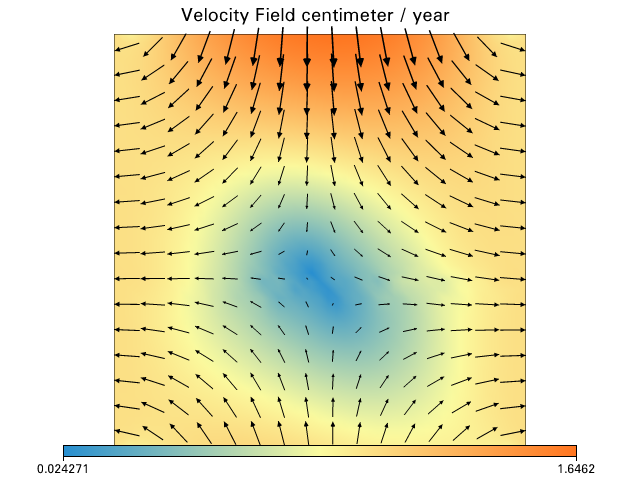


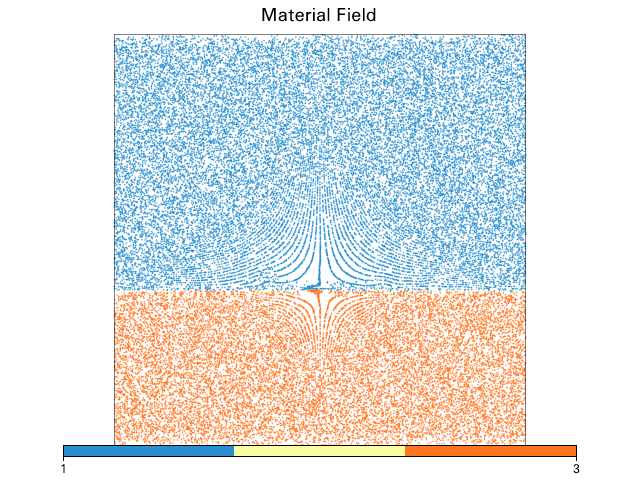

Text(0.5,1,'Subsidence of surface during thinning')

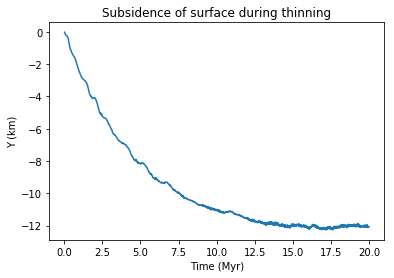

In [17]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

# Summary

Using an open topped model (allowing air inflow) gives us a very similar result as using compressible air. However, because of the high velocity of air coming in the top of the model, the timestep UW takes is about 1/3 less than when using compressible air.

Perhaps on a bigger model (higher resolution), we might expect the cost of this smaller timestep to be offset by being able to use the penalty method?

In [18]:
a = uc.bottom - uc.top
expected_subsidence = ( (500 * u.kilogram / u.metre**3) * a - (1000  * u.kilogram / u.metre**3) * a) / ( (1 * u.kilogram / u.metre**3) - (1000 * u.kilogram / u.metre**3) )
print("Expected subsidence: ", expected_subsidence)
print("Modelled subsidence: ", GEO.Dimensionalize(mswarm.particleCoordinates.data[:,1].copy()[0], u.kilometer))
print("The passive tracer also advected laterally from x = 0 to x = {}".format(GEO.Dimensionalize(mswarm.particleCoordinates.data[:,0].copy()[0], u.kilometer)))

Expected subsidence:  -12.512512512512513 kilometer
Modelled subsidence:  -12.074406746227277 kilometer
The passive tracer also advected laterally from x = 0 to x = -15.159818782712621 kilometer
